## Objectives

1. Identify what ngram works well on datasets unigram, bigram or trigram
2. character n-gram
3. smoothing multiple ngram combinaitons
4. Apply experiment for LR, SVM, MNB models


In [ ]:
import neptune
from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report,log_confusion_matrix,log_prediction_distribution
import os
from dotenv import load_dotenv

load_dotenv()
NEPTUNE_PROJECT= os.getenv('NEPTUNE_PROJECT')
NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
neptune.init(project_qualified_name= NEPTUNE_PROJECT,api_token=NEPTUNE_API_TOKEN) 
             

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score, f1_score, precision_score,roc_curve,roc_auc_score,confusion_matrix,recall_score
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import re
import gensim

# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills

In [1]:
# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills

In [4]:
# load datasets
path = '../Datasets/processed/no_preprocessing/'
df_A = pd.read_csv(path+'df_A.csv') 
df_B = pd.read_csv(path+'df_B.csv')    # fb dataset -kaggle
df_C = pd.read_csv(path+'df_C.csv') 
df_D = pd.read_csv(path+'df_D.csv') 
df_A_B = pd.read_csv(path+'df_A_B.csv') 
df_B_C_D = pd.read_csv(path+'df_B_C_D.csv') 
df_A_B_C = pd.read_csv(path+'df_A_B_C.csv') 
df_A_C_D = pd.read_csv(path+'df_A_C_D.csv') 
df_A_B_D = pd.read_csv(path+'df_A_B_D.csv') 
df_all = pd.read_csv(path+'df_all.csv') 

In [5]:
# load datasets
df_dict = {'df_A': df_A,'df_B': df_B,'df_C' :df_C,'df_D' :df_D,'df_A_B' :df_A_B,'df_A_C_D':df_A_C_D,'df_A_B_C':df_A_B_C,'df_A_B_D':df_A_B_D,'df_B_C_D':df_B_C_D,'df_all':df_all}


In [6]:

def dataset_check(df_list,vectorizer,feature_name,model,model_name):
    
    final_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
    for name,df in df_list.items():
        X_train,X_test,Y_train,Y_test = utills.prepare_dataset(df,name)
        model_pipe, Y_pred = model(X_train,X_test,Y_train,vectorizer,feature_name)
        # gridsearch function and get best parameter for dataset
        gridsearch(model_pipe,param_grid,X_train,Y_train)
        final_result = log_result(Y_test,Y_pred,feature_name,name,final_result,model_name)
         
    
    return final_result
      


In [15]:
def result(y_test, y_pred):
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    classes = np.unique(y_test)
    #y_test_array = pd.get_dummies(y_test, drop_first=False).values
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
#     print("Accuracy:",  round(accuracy, 2))
#     print("Auc:", round(auc, 2))
#     print("Precsion:", round(precision, 2))
#     print("f1_score:", round(f1_score, 2))
#     print("recall:", round(recall, 2))
#     print("Detail:")
    print(metrics.classification_report(y_test, y_pred))

    # Plot confusion matrix
#     cm = metrics.confusion_matrix(y_test, y_pred)
#     fig, ax = plt.subplots()
#     sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
#     ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
#            yticklabels=classes, title="Confusion matrix")
#     plt.yticks(rotation=0)
#     plt.show()
#     utills.PlotRocAuc(y_test, y_pred, 'green', 'LR')
  
    return (accuracy, f1_score, recall, precision, auc)

In [8]:
def log_result(Y_test,Y_pred,feature_name,df_name,final_result,model_name):
    
    
    print("========= Eperiment - ",df_name,' - ', feature_name,' - ',model_name," =========")
    # neptune.create_experiment(df_name+feature_name)
    # neptune.append_tag(['Dataset experiment 3',df_name,feature_name])
    
    # log_class_metrics(Y_test, Y_pred)
    # log_confusion_matrix(Y_test, Y_pred)
    # log_classification_report(Y_test, Y_pred)

    accuracy,f1_score,recall,precision,auc = result(Y_test,Y_pred)
    
    # neptune.log_metric('acc', accuracy)
    # neptune.log_metric('auc', auc)
    # neptune.log_metric('recall', recall)
    # neptune.log_metric('precison', precision)
    # neptune.log_metric('f1_score', f1_score)
    
    
    final_result.loc[df_name] = [accuracy,f1_score,recall,precision,auc]
    
    return final_result

## Gridsearch function for given vectorizer and model

In [ ]:
def gridsearch(clf,param_grid,X_train,Y_train):
    from sklearn.model_selection import GridSearchCV
    #pipeline = Pipeline(steps=[("preprocesser", preprocessor), ("classifier", LogisticRegression())])
    model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

    # Fit Grid Search Model
    model.fit(X_train, Y_train)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
#gridsearch(LR, param_grid, X_train, Y_train)

In [66]:
# initialize pipeline 
bow_vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split())
tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=lambda text: text.split())
pipeline = Pipeline([("feature_extracotr",bow_vectorizer),("classifier",LogisticRegression())])
import numpy as np

In [40]:
import numpy as np

In [88]:
param_grid = [
    # {
    #     "feature_extracotr__ngram_range": [(3, 3), (2, 2),(2,5),(1,3),(2,4)],
    #     "feature_extracotr__binary": [True,False],
    #     "feature_extracotr__analyzer": ['char'],
    #     #'classifier__penalty': ['l2'],
    #     #'classifier__C': [np.logspace(0, 4, 10)],
    #     "classifier__C": [0.1, 1.0, 10.0, 100.0],
    #     "classifier": [LogisticRegression()],
    #     "feature_extracotr":[bow_vectorizer]
    # },
    # {
    #     "feature_extracotr__ngram_range": [(1, 1), (2, 2),(1,2),(1,3),(2,3)],
    #     "feature_extracotr__binary": [True,False],
    #     "feature_extracotr__analyzer": ['word'],
    #     #'classifier__penalty': ['l2'],
    #     #'classifier__C': [np.logspace(0, 4, 10)],
    #     "classifier__C": [0.1, 1.0, 10.0, 100.0],
    #     "classifier": [LogisticRegression()],
    #     "feature_extracotr":[bow_vectorizer]
    # },
    #    {
    #     "feature_extracotr__ngram_range": [(3, 3), (2, 2),(2,5),(1,3),(2,4)],
    #     "feature_extracotr__binary": [True,False],
    #     "feature_extracotr__analyzer": ['char'],
    #     #'classifier__penalty': ['l2'],
    #     #'classifier__C': [np.logspace(0, 4, 10)],
    #     "classifier__C": [0.1, 1.0, 10.0, 100.0],
    #     "classifier": [LogisticRegression()],
    #     "feature_extracotr":[tfidf_vectorizer]
    # },
    #  {
    #     "feature_extracotr__ngram_range": [(1, 1), (2, 2),(1,2),(1,3),(2,3)],
    #     "feature_extracotr__binary": [True,False],
    #     "feature_extracotr__analyzer": ['word'],
    #     #'classifier__penalty': ['l2'],
    #     #'classifier__C': [np.logspace(0, 4, 10)],
    #     "classifier__C": [0.1, 1.0, 10.0, 100.0],
    #     "classifier": [LogisticRegression()],
    #     "feature_extracotr":[tfidf_vectorizer]
    # },





    {
        "feature_extracotr__ngram_range": [(1, 1), (2, 2),(3,3),(1,3),(1,2)],
        "feature_extracotr__analyzer": ['word'],
        #"feature_extracotr__binary": [True,False],
        "classifier__kernel": ['linear', 'rbf'],
        'classifier__C': [0.1, 1.0, 10.0, 100.0],
        "classifier":[SVC()],
        "feature_extracotr":[bow_vectorizer]
    },

    {
        "feature_extracotr__ngram_range": [(1, 1), (2, 2),(3,3),(1,3),(1,2)],
        "feature_extracotr__analyzer": ['word'],
        "feature_extracotr__binary": [True,False],
        "classifier__kernel": ['linear', 'rbf'],
        'classifier__C': [0.1, 1.0, 10.0, 100.0],
        "classifier":[SVC()],
        "feature_extracotr":[tfidf_vectorizer]
    },
    {
        "feature_extracotr__ngram_range": [(2, 6), (2, 4),(3,3),(2,3),(2,5)],
        #"feature_extracotr__binary": [True,False],
        "feature_extracotr__analyzer": ['char'],
        "classifier__kernel": ['linear', 'rbf'],
        'classifier__C': [0.1, 1.0, 10.0, 100.0],
        "classifier":[SVC()],
        "feature_extracotr":[tfidf_vectorizer]
    },
    {
        "feature_extracotr__ngram_range": [(2,6), (2, 4),(3,3),(2,3),(2,5)],
        "feature_extracotr__binary": [True,False],
        "feature_extracotr__analyzer": ['char'],
        "classifier__kernel": ['linear', 'rbf'],
        'classifier__C': [0.1, 1.0, 10.0, 100.0],
        "classifier":[SVC()],
        "feature_extracotr":[bow_vectorizer]
    },


    # {
    #     "feature_extracotr__ngram_range": [(1, 1), (2, 2),(3,3),(1,3),(2,4)],
    #     "feature_extracotr__analyzer": ['char'],
    #     "classifier__alpha": [1e-2, 1e-3],
    #     "classifier":[MultinomialNB()],
    #     "feature_extracotr":[tfidf_vectorizer]
    # },
    # {
    
    #     "feature_extracotr__ngram_range": [(1, 1), (2, 2),(3,3),(1,3),(2,3)],
    #     "feature_extracotr__analyzer": ['word'],
    #     "classifier__alpha": [1e-2, 1e-3],
    #     "classifier":[MultinomialNB()],
    #     "feature_extracotr":[tfidf_vectorizer]
    # }

    # {
    #     "feature_extracotr__": [],
    #     "classifier__n_estimators": [10, 100, 1000],
    #     "classifier": [RandomForestClassifier()]
    # }
]

In [26]:
 X_train,X_test,Y_train,Y_test = utills.prepare_dataset(df_A,"df_A")

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)


In [89]:
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1',cv=5, verbose=2,n_jobs=-1)
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [87]:
print(f"Best params:")
print(grid_search.best_params_)
print("Best score in grid search:")
print(grid_search.best_score_)
print("best logistic regression from grid search:")
print(grid_search.score(X_test, Y_test))

Best params:
{'classifier': LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 100.0, 'feature_extracotr': TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(2, 5), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x0000022E2F3BB048>,
                use_idf=True, vocabulary=None), 'feature_extracotr__analyzer': 'char', 'feature_e

In [74]:
res = pd.DataFrame(grid_search.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__alpha,param_feature_extracotr,param_feature_extracotr__analyzer,param_feature_extracotr__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.508043,0.012483,0.130053,0.017557,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.01,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(1, 1)","{'classifier': MultinomialNB(alpha=0.01, class...",0.000000,0.007067,0.000000,0.000000,0.007092,0.002832,0.003468,19
1,0.856588,0.056394,0.217819,0.020811,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.01,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(2, 2)","{'classifier': MultinomialNB(alpha=0.01, class...",0.509804,0.480392,0.497561,0.465347,0.410390,0.472699,0.034614,18
2,1.344992,0.177758,0.360438,0.088894,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.01,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(3, 3)","{'classifier': MultinomialNB(alpha=0.01, class...",0.657258,0.631365,0.690909,0.638298,0.591667,0.641899,0.032512,7
3,2.853543,0.413621,0.574465,0.033844,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.01,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(1, 3)","{'classifier': MultinomialNB(alpha=0.01, class...",0.658586,0.609603,0.690909,0.649706,0.573222,0.636405,0.040866,8
4,4.273234,1.379706,0.814623,0.037213,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.01,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(2, 4)","{'classifier': MultinomialNB(alpha=0.01, class...",0.661538,0.656371,0.726592,0.692998,0.652908,0.678081,0.028123,1
5,1.185348,0.910479,0.491884,0.668915,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.001,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(1, 1)","{'classifier': MultinomialNB(alpha=0.01, class...",0.000000,0.007067,0.000000,0.000000,0.007092,0.002832,0.003468,19
6,0.867680,0.036169,0.208443,0.027733,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.001,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(2, 2)","{'classifier': MultinomialNB(alpha=0.01, class...",0.508557,0.476658,0.500000,0.467980,0.412371,0.473113,0.033787,17
7,0.995340,0.062257,0.229786,0.023078,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.001,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(3, 3)","{'classifier': MultinomialNB(alpha=0.01, class...",0.646465,0.576842,0.673469,0.593750,0.576271,0.613359,0.039504,13
8,2.241010,0.059480,0.613560,0.059001,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.001,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(1, 3)","{'classifier': MultinomialNB(alpha=0.01, class...",0.631365,0.565957,0.666667,0.607143,0.566596,0.607546,0.038650,14
9,3.428036,0.080537,0.741419,0.153563,"MultinomialNB(alpha=0.01, class_prior=None, fi...",0.001,"TfidfVectorizer(analyzer='char', binary=False,...",char,"(2, 4)","{'classifier': MultinomialNB(alpha=0.01, class...",0.635478,0.614458,0.695146,0.650467,0.631579,0.645425,0.027376,6


## Models

In [18]:
def LR(X_train,X_test,Y_train,vectorizer,feature_name):

    # grid search C=10.0,  penalty='l2'
    #X_train,X_test,Y_train,Y_test = prepare_dataset(df,'comment')
    #C=100.0 , 'feature_extracotr__analyzer': 'char', 'feature_extracotr__binary': False, 'feature_extracotr__ngram_range': (2, 5)},TFIDF  0.74 on test
    lr = LogisticRegression()
    lr_pipe = Pipeline([(feature_name, vectorizer), ('lr', lr)])

    lr_pipe.fit(X_train, Y_train)

    #predictions
    Y_pred = lr_pipe.predict(X_test)
    return (lr_pipe, Y_pred)

# MNB
def MNB(X_train,X_test,Y_train,vectorizer,feature_name):
    # feature_extracotr__binary': True, 'feature_extracotr__ngram_range': (1, 3)}, classifier__alpha': 0.01, word
    # 'feature_extracotr__analyzer': 'char', 'feature_extracotr__ngram_range': (2, 4)
    nb = MultinomialNB()
    nb_pipe = Pipeline([(feature_name, vectorizer), ('nb', nb)])
    nb_pipe.fit(X_train,Y_train)
    #nb.fit(X_train_vectors_tfidf, y_train)  #Predict y value for test dataset
    Y_pred = nb.predict(X_test)
    Y_prob = nb.predict_proba(X_test)[:,1]
    return (nb_pipe, Y_pred)


def svm(X_train,X_test,Y_train,vectorizer,feature_name):
    # C=1.0  kernel='linear'
    svc = SVC()
    svc_pipe = Pipeline([(feature_name, vectorizer), ('svc', svc)])
    svc_pipe.fit(X_train,Y_train)
    #nb.fit(X_train_vectors_tfidf, y_train)  #Predict y value for test dataset
    Y_pred = svc_pipe.predict(X_test)
    return (svc_pipe, Y_pred)

## Logistic Regression Gridsearch

In [ ]:
# bow
bow_vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split())
res_bow = dataset_check({'df_A':df_A},bow_vectorizer,'bow',LR)
res_bow

In [ ]:
# bow
tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=lambda text: text.split())
res_tdidf = dataset_check(df_dict,tfidf_vectorizer,'tfidf')
res_tdidf

## SVM Gridsearch

In [ ]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)),])
_ = text_clf_svm.fit(twenty_train.data, twenty_train.target)
predicted_svm = text_clf_svm.predict(twenty_test.data)
np.mean(predicted_svm == twenty_test.target)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1),(2,2),(3,3),(1,2),(1,3)],
            'tfidf__use_idf': (True, False),
            'clf__alpha': (1e-2, 1e-3),
}

In [ ]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(twenty_train.data, twenty_train.target)

In [ ]:
gs_clf.best_score_
gs_clf.best_params_

In [ ]:
# bow
tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=lambda text: text.split())
res_tdidf = dataset_check(df_dict,tfidf_vectorizer,'tfidf')
res_tdidf

## MNB Gridsearch

# Stop word remove or not

## Obectives

1. LR after stop word remiving for all datasets (A,B,all,B_C_D,A_B_C) for bow/TFIDF features
2. SVM befoe and after stop word removing  for bow,TFIDF
3. Modify dtop word list only remove one that doesn't affect classification

In [10]:

stop_words = List = open('G:\Github\Sinhala-Hate-Speech-Detection\Datasets\stop_words.txt', encoding='utf-8').read().splitlines()
stop_words

['සහ',
 'සමග',
 'සමඟ',
 'අහා',
 'ආහ්',
 'ආ',
 'ඕහෝ',
 'අනේ',
 'අඳෝ',
 'අපොයි',
 'අපෝ',
 'අයියෝ',
 'ආයි',
 'ඌයි',
 'චී',
 'චිහ්',
 'චික්',
 'හෝ\u200d',
 'දෝ',
 'දෝහෝ',
 'මෙන්',
 'සේ',
 'වැනි',
 'බඳු',
 'වන්',
 'අයුරු',
 'අයුරින්',
 'ලෙස',
 'වැඩි',
 'ශ්\u200dරී',
 'හා',
 'ය',
 'නිසා',
 'නිසාවෙන්',
 'බවට',
 'බව',
 'බවෙන්',
 'නම්',
 'වැඩි',
 'සිට',
 'දී',
 'මහා',
 'මහ',
 'පමණ',
 'පමණින්',
 'පමන',
 'වන',
 'විට',
 'විටින්',
 'මේ',
 'මෙලෙස',
 'මෙයින්',
 'ඇති',
 'ලෙස',
 'සිදු',
 'වශයෙන්',
 'යන',
 'සඳහා',
 'මගින්',
 'හෝ\u200d',
 'ඉතා',
 'ඒ',
 'එම',
 'ද',
 'අතර',
 'විසින්',
 'සමග',
 'පිළිබඳව',
 'පිළිබඳ',
 'තුළ',
 'බව',
 'වැනි',
 'මහ',
 'මෙම',
 'මෙහි',
 'මේ',
 'වෙත',
 'වෙතින්',
 'වෙතට',
 'වෙනුවෙන්',
 'වෙනුවට',
 'වෙන',
 'ගැන',
 'නෑ',
 'අනුව',
 'නව',
 'පිළිබඳ',
 'විශේෂ',
 'දැනට',
 'එහෙන්',
 'මෙහෙන්',
 'එහේ',
 'මෙහේ',
 'ම',
 'තවත්',
 'තව ',
 'සහ',
 'දක්වා',
 'ට',
 'ගේ',
 'එ',
 'ක',
 'ක්',
 'බවත්',
 'බවද',
 'මත',
 'ඇතුලු',
 'ඇතුළු',
 'මෙසේ',
 'වඩා',
 'වඩාත්ම',
 'නිති',
 'නිතිත්',
 'නිතොර',
 'නිතර',
 

In [11]:
# modify stop words by emoving words that give sentiment value such as 'අනේ'
remove_stop_words = ['ඕහෝ',
 'අනේ',
 'අඳෝ',
 'අපොයි',
 'අපෝ',
 'අයියෝ',
 'ආයි',
 'ඌයි',
 'චී',
 'චිහ්',
 'චික්','නෑ', 'එම්බා','එම්බල','බොල']
for w in remove_stop_words:
    if w in stop_words:
        stop_words.remove(w)
stop_words

['සහ',
 'සමග',
 'සමඟ',
 'අහා',
 'ආහ්',
 'ආ',
 'හෝ\u200d',
 'දෝ',
 'දෝහෝ',
 'මෙන්',
 'සේ',
 'වැනි',
 'බඳු',
 'වන්',
 'අයුරු',
 'අයුරින්',
 'ලෙස',
 'වැඩි',
 'ශ්\u200dරී',
 'හා',
 'ය',
 'නිසා',
 'නිසාවෙන්',
 'බවට',
 'බව',
 'බවෙන්',
 'නම්',
 'වැඩි',
 'සිට',
 'දී',
 'මහා',
 'මහ',
 'පමණ',
 'පමණින්',
 'පමන',
 'වන',
 'විට',
 'විටින්',
 'මේ',
 'මෙලෙස',
 'මෙයින්',
 'ඇති',
 'ලෙස',
 'සිදු',
 'වශයෙන්',
 'යන',
 'සඳහා',
 'මගින්',
 'හෝ\u200d',
 'ඉතා',
 'ඒ',
 'එම',
 'ද',
 'අතර',
 'විසින්',
 'සමග',
 'පිළිබඳව',
 'පිළිබඳ',
 'තුළ',
 'බව',
 'වැනි',
 'මහ',
 'මෙම',
 'මෙහි',
 'මේ',
 'වෙත',
 'වෙතින්',
 'වෙතට',
 'වෙනුවෙන්',
 'වෙනුවට',
 'වෙන',
 'ගැන',
 'අනුව',
 'නව',
 'පිළිබඳ',
 'විශේෂ',
 'දැනට',
 'එහෙන්',
 'මෙහෙන්',
 'එහේ',
 'මෙහේ',
 'ම',
 'තවත්',
 'තව ',
 'සහ',
 'දක්වා',
 'ට',
 'ගේ',
 'එ',
 'ක',
 'ක්',
 'බවත්',
 'බවද',
 'මත',
 'ඇතුලු',
 'ඇතුළු',
 'මෙසේ',
 'වඩා',
 'වඩාත්ම',
 'නිති',
 'නිතිත්',
 'නිතොර',
 'නිතර',
 'ඉක්බිති',
 'දැන්',
 'යලි',
 'පුන',
 'ඉතින්',
 'සිට',
 'සිටන්',
 'පටන්',
 'තෙක්',
 'දක්වා',
 'සා',
 

## Logistic regression + BOW

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
========= Eperiment -  df_A  -  bow  -  LR  =========
Accuracy: 0.82
Auc: 0.76
Precsion: 0.78
f1_score: 0.68
recall: 0.6
Detail:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1337
           1       0.78      0.60      0.68       604

    accuracy                           0.82      1941
   macro avg       0.81      0.76      0.78      1941
weighted avg       0.82      0.82      0.82      1941



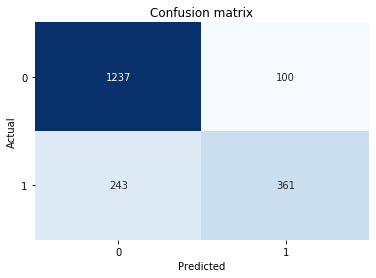

df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
========= Eperiment -  df_B  -  bow  -  LR  =========
Accuracy: 0.84
Auc: 0.85
Precsion: 0.89
f1_score: 0.85
recall: 0.81
Detail:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       867
           1       0.89      0.81      0.85      1037

    accuracy                           0.84      1904
   macro avg       0.84      0.85      0.84      1904
weighted avg       0.85      0.84      0.84      1904



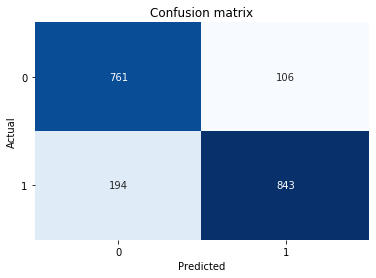

df_C 1411
X train (987,) Y train (987,) X test (424,) Y test (424,)
========= Eperiment -  df_C  -  bow  -  LR  =========
Accuracy: 0.9
Auc: 0.82
Precsion: 0.88
f1_score: 0.77
recall: 0.68
Detail:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       325
           1       0.88      0.68      0.77        99

    accuracy                           0.90       424
   macro avg       0.89      0.82      0.85       424
weighted avg       0.90      0.90      0.90       424



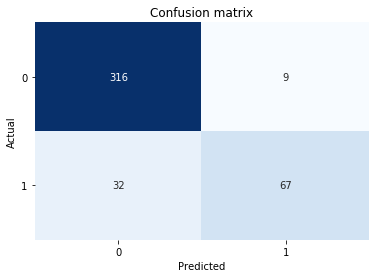

df_D 1446
X train (1012,) Y train (1012,) X test (434,) Y test (434,)
========= Eperiment -  df_D  -  bow  -  LR  =========
Accuracy: 0.66
Auc: 0.65
Precsion: 0.68
f1_score: 0.57
recall: 0.5
Detail:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72       235
           1       0.68      0.50      0.57       199

    accuracy                           0.66       434
   macro avg       0.67      0.65      0.65       434
weighted avg       0.66      0.66      0.65       434



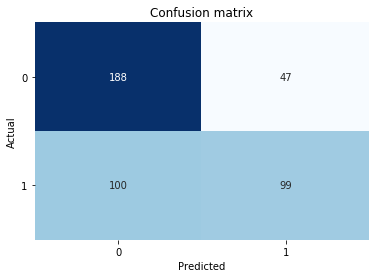

df_A_B 12813
X train (8969,) Y train (8969,) X test (3844,) Y test (3844,)
========= Eperiment -  df_A_B  -  bow  -  LR  =========
Accuracy: 0.82
Auc: 0.81
Precsion: 0.84
f1_score: 0.77
recall: 0.72
Detail:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2204
           1       0.84      0.72      0.77      1640

    accuracy                           0.82      3844
   macro avg       0.83      0.81      0.81      3844
weighted avg       0.82      0.82      0.82      3844



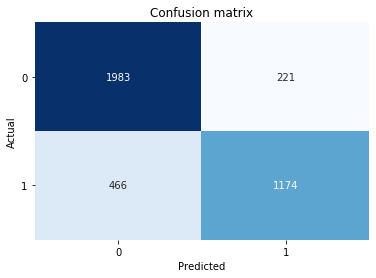

df_A_C_D 9325
X train (6527,) Y train (6527,) X test (2798,) Y test (2798,)
========= Eperiment -  df_A_C_D  -  bow  -  LR  =========
Accuracy: 0.8
Auc: 0.73
Precsion: 0.76
f1_score: 0.63
recall: 0.54
Detail:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1896
           1       0.76      0.54      0.63       902

    accuracy                           0.80      2798
   macro avg       0.78      0.73      0.75      2798
weighted avg       0.79      0.80      0.79      2798



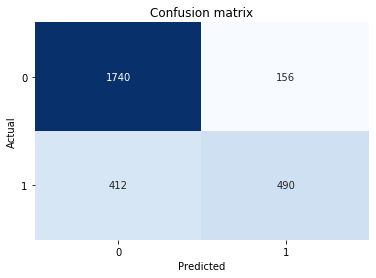

df_A_B_C 14224
X train (9956,) Y train (9956,) X test (4268,) Y test (4268,)
========= Eperiment -  df_A_B_C  -  bow  -  LR  =========
Accuracy: 0.83
Auc: 0.81
Precsion: 0.85
f1_score: 0.77
recall: 0.71
Detail:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2529
           1       0.85      0.71      0.77      1739

    accuracy                           0.83      4268
   macro avg       0.83      0.81      0.82      4268
weighted avg       0.83      0.83      0.82      4268



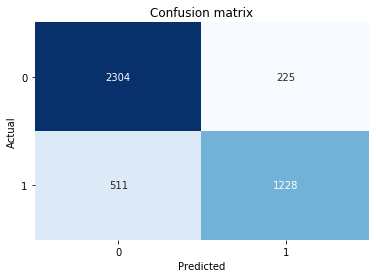

df_A_B_D 14259
X train (9981,) Y train (9981,) X test (4278,) Y test (4278,)
========= Eperiment -  df_A_B_D  -  bow  -  LR  =========
Accuracy: 0.81
Auc: 0.8
Precsion: 0.84
f1_score: 0.76
recall: 0.7
Detail:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2439
           1       0.84      0.70      0.76      1839

    accuracy                           0.81      4278
   macro avg       0.82      0.80      0.80      4278
weighted avg       0.82      0.81      0.81      4278



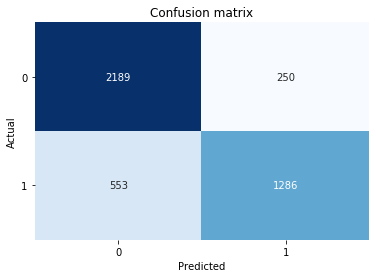

df_B_C_D 9202
X train (6441,) Y train (6441,) X test (2761,) Y test (2761,)
========= Eperiment -  df_B_C_D  -  bow  -  LR  =========
Accuracy: 0.83
Auc: 0.83
Precsion: 0.85
f1_score: 0.82
recall: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1426
           1       0.85      0.78      0.82      1335

    accuracy                           0.83      2761
   macro avg       0.83      0.83      0.83      2761
weighted avg       0.83      0.83      0.83      2761



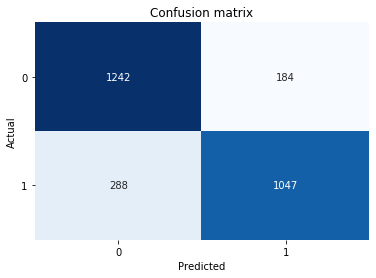

df_all 15670
X train (10969,) Y train (10969,) X test (4701,) Y test (4701,)
========= Eperiment -  df_all  -  bow  -  LR  =========
Accuracy: 0.82
Auc: 0.8
Precsion: 0.84
f1_score: 0.76
recall: 0.7
Detail:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86      2763
           1       0.84      0.70      0.76      1938

    accuracy                           0.82      4701
   macro avg       0.82      0.80      0.81      4701
weighted avg       0.82      0.82      0.82      4701



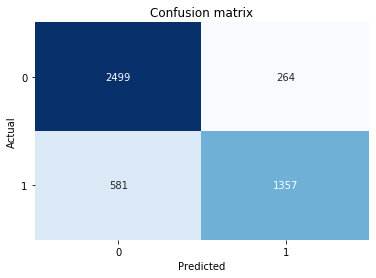

,Accuracy,F1-score,Recall,Precision,AUC
df_A,0.823287,0.677934,0.597682,0.783080,0.761444
df_B,0.842437,0.848943,0.812922,0.888303,0.845331
df_C,0.903302,0.765714,0.676768,0.881579,0.824538
df_D,0.661290,0.573913,0.497487,0.678082,0.648744
df_A_B,0.821280,0.773641,0.715854,0.841577,0.807791
df_A_C_D,0.796998,0.633075,0.543237,0.758514,0.730479
df_A_B_C,0.827554,0.769424,0.706153,0.845148,0.808592
df_A_B_D,0.812295,0.762074,0.699293,0.837240,0.798396
df_B_C_D,0.829047,0.816056,0.784270,0.850528,0.827619
df_all,0.820251,0.762574,0.700206,0.837138,0.802329


In [14]:
# bow
bow_vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split(),stop_words = stop_words)
res_bow = dataset_check(df_dict,bow_vectorizer,'bow',LR,"LR")
res_bow

## LR + TFIFF

In [16]:
# bow
tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=lambda text: text.split(),stop_words = stop_words)
res_tdidf = dataset_check(df_dict,tfidf_vectorizer,'tfidf',LR,"LR")
res_tdidf

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
========= Eperiment -  df_A  -  tfidf  -  LR  =========
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1337
           1       0.85      0.44      0.58       604

    accuracy                           0.80      1941
   macro avg       0.82      0.70      0.73      1941
weighted avg       0.81      0.80      0.78      1941

df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
========= Eperiment -  df_B  -  tfidf  -  LR  =========
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       867
           1       0.86      0.87      0.86      1037

    accuracy                           0.85      1904
   macro avg       0.85      0.85      0.85      1904
weighted avg       0.85      0.85      0.85      1904

df_C 1411
X train (987,) Y train (987,) X test (424,) Y test (424,)
========= Eperiment - 

,Accuracy,F1-score,Recall,Precision,AUC
df_A,0.803194,0.583878,0.443709,0.853503,0.704652
df_B,0.851891,0.864293,0.865959,0.862632,0.850511
df_C,0.827830,0.425197,0.272727,0.964286,0.634825
df_D,0.679724,0.582583,0.487437,0.723881,0.664995
df_A_B,0.822320,0.769646,0.695732,0.861132,0.806124
df_A_C_D,0.779128,0.557940,0.432373,0.786290,0.688233
df_A_B_C,0.821696,0.753801,0.669925,0.861686,0.797991
df_A_B_D,0.813464,0.758767,0.682436,0.854323,0.797348
df_B_C_D,0.822166,0.809172,0.779775,0.840872,0.820813
df_all,0.813019,0.745144,0.663055,0.850430,0.790630


## SVM + BOW - With stop words

In [19]:
# bow
bow_vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split())
res_bow = dataset_check(df_dict,bow_vectorizer,'bow',svm,"svm")
res_bow

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
========= Eperiment -  df_A  -  bow  -  svm  =========
              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1337
           1       0.87      0.39      0.54       604

    accuracy                           0.79      1941
   macro avg       0.83      0.68      0.70      1941
weighted avg       0.81      0.79      0.77      1941

df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
========= Eperiment -  df_B  -  bow  -  svm  =========
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       867
           1       0.86      0.77      0.81      1037

    accuracy                           0.81      1904
   macro avg       0.81      0.81      0.81      1904
weighted avg       0.81      0.81      0.81      1904

df_C 1411
X train (987,) Y train (987,) X test (424,) Y test (424,)
========= Eperiment -  d

,Accuracy,F1-score,Recall,Precision,AUC
df_A,0.793405,0.541714,0.392384,0.874539,0.683477
df_B,0.805672,0.812563,0.773385,0.855923,0.808838
df_C,0.865566,0.632258,0.494949,0.875000,0.736706
df_D,0.631336,0.455782,0.336683,0.705263,0.608767
df_A_B,0.801509,0.729144,0.626220,0.872557,0.779081
df_A_C_D,0.774482,0.530855,0.395787,0.805869,0.675214
df_A_B_C,0.812324,0.731658,0.627947,0.876404,0.783527
df_A_B_D,0.801309,0.731522,0.629690,0.872645,0.780200
df_B_C_D,0.805505,0.784770,0.733333,0.843966,0.803202
df_all,0.801744,0.717404,0.610423,0.869853,0.773181


## SVM + BOW - Without stop words

In [20]:
# bow
bow_vectorizer = CountVectorizer(analyzer="word", tokenizer=lambda text: text.split(),stop_words = stop_words)
res_bow = dataset_check(df_dict,bow_vectorizer,'bow',svm,"svm")
res_bow

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
========= Eperiment -  df_A  -  bow  -  svm  =========
              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1337
           1       0.87      0.39      0.54       604

    accuracy                           0.79      1941
   macro avg       0.82      0.68      0.70      1941
weighted avg       0.81      0.79      0.77      1941

df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
========= Eperiment -  df_B  -  bow  -  svm  =========
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       867
           1       0.86      0.76      0.81      1037

    accuracy                           0.81      1904
   macro avg       0.81      0.81      0.81      1904
weighted avg       0.81      0.81      0.81      1904

df_C 1411
X train (987,) Y train (987,) X test (424,) Y test (424,)
========= Eperiment -  d

,Accuracy,F1-score,Recall,Precision,AUC
df_A,0.792890,0.542141,0.394040,0.868613,0.683557
df_B,0.805672,0.810838,0.764706,0.862894,0.809689
df_C,0.865566,0.632258,0.494949,0.875000,0.736706
df_D,0.640553,0.469388,0.346734,0.726316,0.618048
df_A_B,0.806712,0.738104,0.638415,0.874687,0.785178
df_A_C_D,0.774124,0.530461,0.395787,0.804054,0.674951
df_A_B_C,0.813730,0.734025,0.630822,0.877600,0.785162
df_A_B_D,0.798504,0.729271,0.631321,0.863197,0.777940
df_B_C_D,0.808403,0.787465,0.734082,0.849220,0.806031
df_all,0.803233,0.719952,0.613519,0.871062,0.774910


## SVM + TFIDF - with stop words

In [21]:
# bow
tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=lambda text: text.split())
res_tdidf = dataset_check(df_dict,tfidf_vectorizer,'tfidf',svm,"svm")
res_tdidf

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
========= Eperiment -  df_A  -  tfidf  -  svm  =========
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1337
           1       0.86      0.47      0.60       604

    accuracy                           0.81      1941
   macro avg       0.83      0.72      0.74      1941
weighted avg       0.82      0.81      0.79      1941

df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
========= Eperiment -  df_B  -  tfidf  -  svm  =========
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       867
           1       0.86      0.86      0.86      1037

    accuracy                           0.85      1904
   macro avg       0.85      0.85      0.85      1904
weighted avg       0.85      0.85      0.85      1904

df_C 1411
X train (987,) Y train (987,) X test (424,) Y test (424,)
========= Eperiment 

,Accuracy,F1-score,Recall,Precision,AUC
df_A,0.810922,0.604952,0.465232,0.864615,0.716161
df_B,0.847164,0.860432,0.864995,0.855916,0.845416
df_C,0.846698,0.518519,0.353535,0.972222,0.675229
df_D,0.679724,0.561514,0.447236,0.754237,0.661916
df_A_B,0.827263,0.774610,0.695732,0.873660,0.810434
df_A_C_D,0.785204,0.577058,0.454545,0.789981,0.698528
df_A_B_C,0.828491,0.764933,0.684876,0.866182,0.806060
df_A_B_D,0.816503,0.761616,0.681892,0.862448,0.799946
df_B_C_D,0.829047,0.817337,0.791011,0.845476,0.827834
df_all,0.820676,0.756288,0.674923,0.859961,0.798916


## SVM + TFIDF - without stop words

In [22]:
# bow
tfidf_vectorizer = TfidfVectorizer(analyzer="word", tokenizer=lambda text: text.split(),stop_words = stop_words)
res_tdidf = dataset_check(df_dict,tfidf_vectorizer,'tfidf',svm,"svm")
res_tdidf

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
========= Eperiment -  df_A  -  tfidf  -  svm  =========
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1337
           1       0.87      0.46      0.60       604

    accuracy                           0.81      1941
   macro avg       0.84      0.72      0.74      1941
weighted avg       0.82      0.81      0.79      1941

df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
========= Eperiment -  df_B  -  tfidf  -  svm  =========
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       867
           1       0.86      0.86      0.86      1037

    accuracy                           0.85      1904
   macro avg       0.85      0.85      0.85      1904
weighted avg       0.85      0.85      0.85      1904

df_C 1411
X train (987,) Y train (987,) X test (424,) Y test (424,)
========= Eperiment 

,Accuracy,F1-score,Recall,Precision,AUC
df_A,0.811437,0.603037,0.460265,0.874214,0.715174
df_B,0.850840,0.863330,0.864995,0.861671,0.849453
df_C,0.849057,0.529412,0.363636,0.972973,0.680280
df_D,0.675115,0.549521,0.432161,0.754386,0.656506
df_A_B,0.825963,0.772835,0.693902,0.872031,0.809066
df_A_C_D,0.785561,0.575672,0.451220,0.794922,0.697920
df_A_B_C,0.830366,0.766301,0.682576,0.873436,0.807283
df_A_B_D,0.818841,0.764509,0.684067,0.866391,0.802263
df_B_C_D,0.828685,0.816880,0.790262,0.845353,0.827459
df_all,0.821102,0.756866,0.675439,0.860618,0.799355
